In [11]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module 
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Hidden layer with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output Layer
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [4]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.604..  Test Loss: 0.470..  Test Accuracy: 0.827
Epoch: 2/30..  Training Loss: 0.481..  Test Loss: 0.464..  Test Accuracy: 0.837
Epoch: 3/30..  Training Loss: 0.446..  Test Loss: 0.439..  Test Accuracy: 0.838
Epoch: 4/30..  Training Loss: 0.436..  Test Loss: 0.405..  Test Accuracy: 0.857
Epoch: 5/30..  Training Loss: 0.421..  Test Loss: 0.403..  Test Accuracy: 0.854
Epoch: 6/30..  Training Loss: 0.412..  Test Loss: 0.398..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.392..  Test Accuracy: 0.863
Epoch: 8/30..  Training Loss: 0.395..  Test Loss: 0.379..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.396..  Test Loss: 0.380..  Test Accuracy: 0.865
Epoch: 10/30..  Training Loss: 0.389..  Test Loss: 0.391..  Test Accuracy: 0.865
Epoch: 11/30..  Training Loss: 0.387..  Test Loss: 0.430..  Test Accuracy: 0.854
Epoch: 12/30..  Training Loss: 0.390..  Test Loss: 0.385..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.374.

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

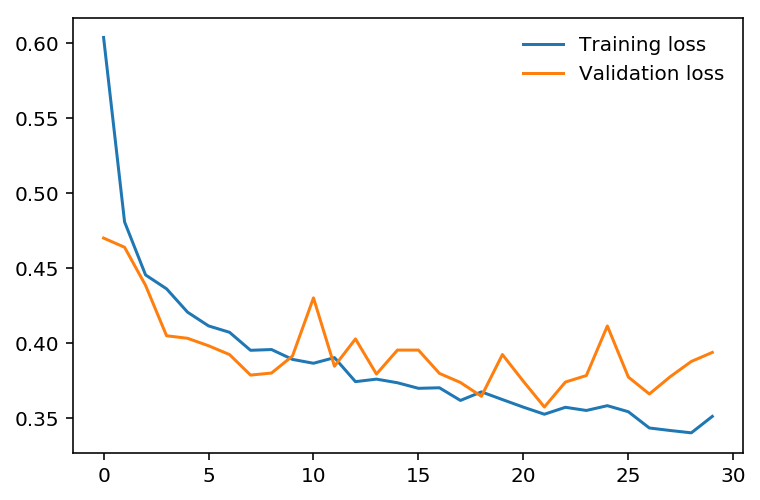

In [6]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [7]:
model.eval()
dataiter=iter(testloader)
images, labels = dataiter.next()
img=images[0]
img=img.view(1,784)

with torch.no_grad():
    output=model.forward(img)

ps=torch.exp(output)
print(ps)


tensor([[2.7704e-22, 3.1493e-22, 3.8664e-22, 4.4901e-18, 3.9061e-23, 1.8467e-06,
         1.1038e-25, 1.0000e+00, 1.3852e-11, 6.9618e-07]])


In [8]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


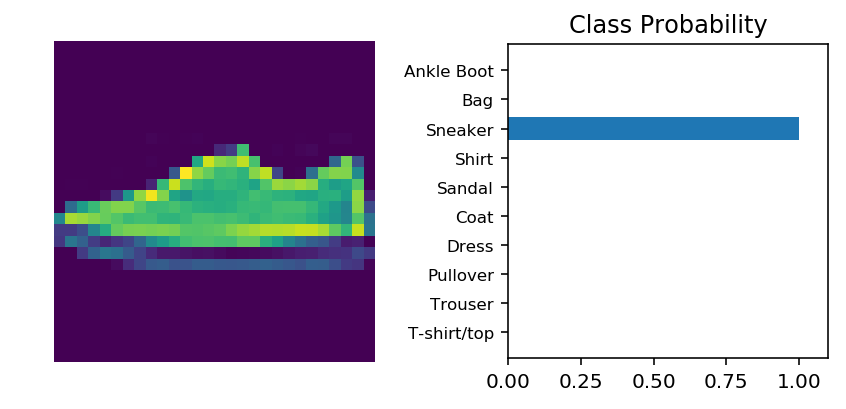

In [12]:
view_classify(img.view(1, 28, 28), ps, version='Fashion')